In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import time 
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set default tensor type to float32
torch.set_default_tensor_type(torch.FloatTensor)

Using device: cuda


/venv/main/lib/python3.10/site-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


# Normalizer

In [2]:
class Normalizer:
    def __init__(self, x_min, x_max):
        self.x_min = x_min
        self.x_max = x_max
        
    def normalize(self, x):
        return 2.0 * (x - self.x_min) / (self.x_max - self.x_min) - 1.0
        
    def denormalize(self, x_norm):
        return 0.5 * (x_norm + 1.0) * (self.x_max - self.x_min) + self.x_min

# ANN

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.x_normalizer = Normalizer(x_min=0.0, x_max=10.0)
        self.y_normalizer = Normalizer(x_min=0.0, x_max=5.0) 
        
        # Network architecture
        self.hidden1 = nn.Linear(2, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.hidden3 = nn.Linear(128, 128)
        self.hidden4 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 2)
        
    def forward(self, xy):
        x_norm = self.x_normalizer.normalize(xy[:, 0:1])
        y_norm = self.y_normalizer.normalize(xy[:, 1:2])
        xy_norm = torch.cat([x_norm, y_norm], dim=1)
        
        h = torch.tanh(self.hidden1(xy_norm))
        h = torch.tanh(self.hidden2(h))
        h = torch.tanh(self.hidden3(h))
        h = torch.tanh(self.hidden4(h))
        output = self.output(h)
        
        u, v = output[:, 0:1], output[:, 1:2]
        
        return torch.cat([u, v], dim=1)

# Vertice

In [4]:
import numpy as np
import torch
from matplotlib.path import Path

# Geometry definition
vertices = np.array([
    [0, 0],
    [0, 5],
    [5, 5],
    [8, 2],
    [10, 2],
    [10, 0],
    [0, 0]  # Closing the polygon
], dtype=np.float32)

path = Path(vertices)

def in_domain(x, y):
    points = np.column_stack((x.cpu().numpy(), y.cpu().numpy()))
    return torch.tensor(path.contains_points(points), dtype=torch.bool, device=x.device)

# Fixed boundary conditions - NO OVERLAP
def BC_bottom(x, y, tol=1e-6):
    
    return (torch.abs(y) < tol) & (x >= -tol) & (x <= 10 + tol)

def BC_top(x, y, tol=1e-6):
    
    # Top left horizontal: y = 5, x = [0, 5] (includes left corner)
    top_left = (torch.abs(y - 5) < tol) & (x >= -tol) & (x <= 5 + tol)
    
    # Top right horizontal: y = 2, x = [8, 10] (includes right corner)
    top_right = (torch.abs(y - 2) < tol) & (x >= 8 - tol) & (x <= 10 + tol)
    
    return (top_left | top_right).squeeze()

def BC_left(x, y, tol=1e-6):
   
    return (torch.abs(x) < tol) & (y >= tol) & (y <= 5 - tol)

def BC_right(x, y, tol=1e-6):
    
    return (torch.abs(x - 10) < tol) & (y >= tol) & (y <= 2 - tol)

def BC_Slope(x, y, tol=1e-6):
    
    # Slope equation: y + x = 10
    slope_condition = torch.abs((y + x) - 10) < tol
    # Exclude corners by being more restrictive
    x_range = (x >= 5 + tol) & (x <= 8 - tol)
    
    return (slope_condition & x_range).squeeze()

# Huber loss

In [5]:
class HuberLoss:
    def __init__(self, delta=1.0):    #<------------------------ Delta Huber loss
        self.delta = delta
        
    def __call__(self, y_true, y_pred):
        error = torch.abs(y_true - y_pred)
        quadratic = torch.min(error, torch.tensor(self.delta))
        linear = error - quadratic
        return torch.mean(0.5 * quadratic ** 2 + self.delta * linear)

# BC Loss

In [6]:
def BC(xy, net):

    x, y = xy[:, 0], xy[:, 1]
    
    uv = net(xy)
    u, v = uv[:, 0], uv[:, 1]
    
    # Get raw BC masks
    bc_b_raw = BC_bottom(x, y)     
    bc_l_raw = BC_left(x, y)
    bc_t_raw = BC_top(x, y)
    bc_r_raw = BC_right(x, y)
    bc_s_raw = BC_Slope(x, y)
    
    # Apply hierarchy to resolve overlaps
    bc_t = bc_t_raw  # Top has highest priority
    bc_b = bc_b_raw & ~bc_t  # Bottom excludes top
    bc_s = bc_s_raw & ~bc_t & ~bc_b  # Slope excludes top and bottom
    bc_r = bc_r_raw & ~bc_t & ~bc_b & ~bc_s  # Right excludes higher priorities
    bc_l = bc_l_raw & ~bc_t & ~bc_b & ~bc_s & ~bc_r  # Left has lowest priority
    
    E = 50  # Young's modulus
    nu = 0.3  # Poisson's ratio
    loss = torch.tensor(0.0, requires_grad=True)
    #huber = HuberLoss(delta=0.5)
    
    # Apply boundary conditions
    
    # 1. Bottom boundary: Fixed (u = v = 0)
    if torch.any(bc_b):
        loss = loss + F.mse_loss(u[bc_b], torch.zeros_like(u[bc_b]))
        loss = loss + F.mse_loss(v[bc_b], torch.zeros_like(v[bc_b]))
    
    # 2. Top boundary: Stress-free (σyy = 0, σxy = 0)
    if torch.any(bc_t):
        xy_top = xy[bc_t]
        xy_top.requires_grad_(True)
        uv_top = net(xy_top)
        u_top, v_top = uv_top[:, 0], uv_top[:, 1]
        
        u_x_top = torch.autograd.grad(u_top.sum(), xy_top, create_graph=True)[0][:, 0]
        u_y_top = torch.autograd.grad(u_top.sum(), xy_top, create_graph=True)[0][:, 1]
        v_x_top = torch.autograd.grad(v_top.sum(), xy_top, create_graph=True)[0][:, 0]
        v_y_top = torch.autograd.grad(v_top.sum(), xy_top, create_graph=True)[0][:, 1]
        
        sigma_yy_top = E / (1 - nu**2) * (v_y_top + nu * u_x_top)
        sigma_xy_top = E / (2 * (1 + nu)) * (u_y_top + v_x_top)
        loss = loss + F.mse_loss(sigma_yy_top, torch.zeros_like(sigma_yy_top))
        loss = loss + F.mse_loss(sigma_xy_top, torch.zeros_like(sigma_xy_top))
    
    # 3. Slope boundary: Stress-free with coordinate transformation
    if torch.any(bc_s):
        xy_slope = xy[bc_s]
        xy_slope.requires_grad_(True)
        uv_slope = net(xy_slope)
        u_slope, v_slope = uv_slope[:, 0], uv_slope[:, 1]
        
        # Calculate gradients
        u_x_slope = torch.autograd.grad(u_slope.sum(), xy_slope, create_graph=True)[0][:, 0]
        u_y_slope = torch.autograd.grad(u_slope.sum(), xy_slope, create_graph=True)[0][:, 1]
        v_x_slope = torch.autograd.grad(v_slope.sum(), xy_slope, create_graph=True)[0][:, 0]
        v_y_slope = torch.autograd.grad(v_slope.sum(), xy_slope, create_graph=True)[0][:, 1]
        
        # Calculate stress components
        sigma_xx_slope = E / (1 - nu**2) * (u_x_slope + nu * v_y_slope)
        sigma_yy_slope = E / (1 - nu**2) * (v_y_slope + nu * u_x_slope)
        sigma_xy_slope = E / (2 * (1 + nu)) * (u_y_slope + v_x_slope)
        
        # Coordinate transformation for 45° slope
        sqrt2 = torch.sqrt(torch.tensor(2.0, device=xy_slope.device))
        nx, ny = 1/sqrt2, 1/sqrt2  # Normal vector
        tx, ty = 1/sqrt2, -1/sqrt2  # Tangent vector
        
        sigma_n = nx**2 * sigma_xx_slope + ny**2 * sigma_yy_slope + 2*nx*ny * sigma_xy_slope
        tau_nt = tx*nx * (sigma_xx_slope - sigma_yy_slope) + (tx*ny + ty*nx) * sigma_xy_slope
        
        loss = loss + F.mse_loss(sigma_n, torch.zeros_like(sigma_n))
        loss = loss + F.mse_loss(tau_nt, torch.zeros_like(tau_nt))
    
    # 4. Right boundary: Roller (u = 0, σxy = 0)
    if torch.any(bc_r):
        xy_right = xy[bc_r]
        xy_right.requires_grad_(True)
        uv_right = net(xy_right)
        u_right, v_right = uv_right[:, 0], uv_right[:, 1]
        
        u_y_right = torch.autograd.grad(u_right.sum(), xy_right, create_graph=True)[0][:, 1]
        v_x_right = torch.autograd.grad(v_right.sum(), xy_right, create_graph=True)[0][:, 0]
        
        sigma_xy_right = E / (2 * (1 + nu)) * (u_y_right + v_x_right)
        loss = loss + F.mse_loss(u_right, torch.zeros_like(u_right))
        loss = loss + F.mse_loss(sigma_xy_right, torch.zeros_like(sigma_xy_right))
    
    # 5. Left boundary: Roller (u = 0, σxy = 0)
    if torch.any(bc_l):
        xy_left = xy[bc_l]
        xy_left.requires_grad_(True)
        uv_left = net(xy_left)
        u_left, v_left = uv_left[:, 0], uv_left[:, 1]
        
        u_y_left = torch.autograd.grad(u_left.sum(), xy_left, create_graph=True)[0][:, 1]
        v_x_left = torch.autograd.grad(v_left.sum(), xy_left, create_graph=True)[0][:, 0]
        
        sigma_xy_left = E / (2 * (1 + nu)) * (u_y_left + v_x_left)
        loss = loss + F.mse_loss(u_left, torch.zeros_like(u_left))
        loss = loss + F.mse_loss(sigma_xy_left, torch.zeros_like(sigma_xy_left))

    return loss

# Adaptive sampling

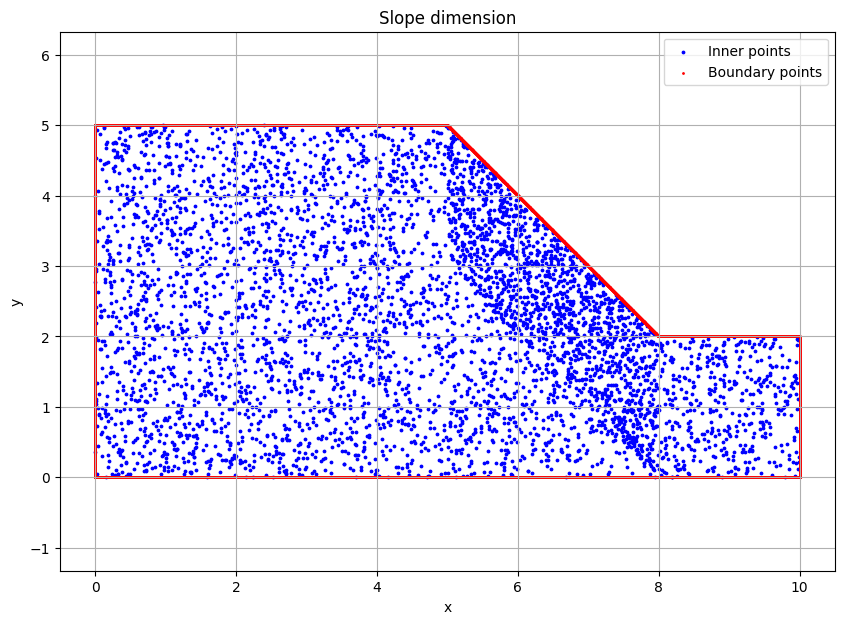


--- Number of point in Domain ---
(inner points): 4976
(boundary points): 15000
Total point: 19976
Area: 39.5 units
Density: 125.97 points/unit


In [7]:
def in_domain(x, y):
    mask_top_straight = (x >= 0) & (x <= 5) & (y <= 5)
    tol = 1e-6
    slope_line = (x > 5) & (x < 8) & (y <= (-x + 10.0 + tol))
    mask_top_right = (x >= 8) & (x <= 10.0) & (y <= 2)
    mask = (x >= 0) & (x <= 10.0) & (y >= 0) & (
        mask_top_straight | slope_line | mask_top_right
    )
    return mask

# function to generate random points
def generate_random_points(n_inner=5000, n_slope=2000, delta=2, n_boundary=5000):
    
    x_inner = torch.rand(n_inner, device=device) * 10.0  # x ระหว่าง 0 ถึง 10
    y_inner = torch.rand(n_inner, device=device) * 5.0   # y ระหว่าง 0 ถึง 5
    mask = in_domain(x_inner, y_inner)
    x_inner = x_inner[mask]
    y_inner = y_inner[mask]

    
    x_slope = 5.0 + torch.rand(n_slope, device=device) * 3.0  # x ระหว่าง 5 ถึง 8
    y_center = -x_slope + 10.0                                # y บนเส้น Slope
    y_slope = y_center + (torch.rand(n_slope, device=device) - 0.5) * 2 * delta  # y รอบเส้น Slope
    mask_slope = in_domain(x_slope, y_slope)
    x_slope = x_slope[mask_slope]
    y_slope = y_slope[mask_slope]

    #Total points
    x_all = torch.cat([x_inner, x_slope])
    y_all = torch.cat([y_inner, y_slope])

    
    t = torch.linspace(0, 1, n_boundary, device=device)
    segments = [
        ([0, 0, 0], [0, 5, 5]),
        ([0, 5, 8, 10, 10], [5, 5, 2, 2, 0]),
        ([10, 0], [0, 0])
    ]
    x_b, y_b = [], []
    for segment in segments:
        x_seg = torch.tensor(np.interp(t.cpu().numpy(), np.linspace(0, 1, len(segment[0])), segment[0]), dtype=torch.float32, device=device)
        y_seg = torch.tensor(np.interp(t.cpu().numpy(), np.linspace(0, 1, len(segment[1])), segment[1]), dtype=torch.float32, device=device)
        x_b.append(x_seg)
        y_b.append(y_seg)

    x_b = torch.cat(x_b).view(-1)
    y_b = torch.cat(y_b).view(-1)

    return x_all, y_all, x_b, y_b


x_inner, y_inner, x_b, y_b = generate_random_points(n_inner=5000, n_slope=2000, delta=2)

plt.figure(figsize=(10, 7))
plt.scatter(x_inner.cpu(), y_inner.cpu(), s=3,marker='o', color='blue', label='Inner points')
plt.scatter(x_b.cpu(), y_b.cpu(), s=1, color='red', label='Boundary points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Slope dimension')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


print("\n--- Number of point in Domain ---")
print(f"(inner points): {len(x_inner)}")
print(f"(boundary points): {len(x_b)}")
print(f"Total point: {len(x_inner) + len(x_b)}")


area_rectangle = 5 * 5  # พื้นที่สี่เหลี่ยมด้านซ้าย (0-5, 0-5)
area_trapezoid = (5 + 2) * 3 / 2  # พื้นที่สี่เหลี่ยมคางหมูกลาง (ความสูง=3, ด้านคู่ขนาน=5,2)
area_rectangle_right = 2 * 2  # พื้นที่สี่เหลี่ยมด้านขวา (8-10, 0-2)
total_area = area_rectangle + area_trapezoid + area_rectangle_right

print(f"Area: {total_area} units")
print(f"Density: {len(x_inner) / total_area:.2f} points/unit")

In [8]:
def check_bc_overlap_simple(xy):

    x, y = xy[:, 0], xy[:, 1]
    
    # Get all BC masks
    bc_b = BC_bottom(x, y)
    bc_l = BC_left(x, y)
    bc_t = BC_top(x, y)
    bc_r = BC_right(x, y)
    bc_s = BC_Slope(x, y)
    
    total_points = len(xy)
    
    print("=" * 50)
    print("BC OVERLAP CHECK")
    print("=" * 50)
    print(f"Total points: {total_points}")
    
    # Count points in each BC
    print("\nBC Coverage:")
    print(f"Bottom: {torch.sum(bc_b)} points")
    print(f"Left:   {torch.sum(bc_l)} points")
    print(f"Top:    {torch.sum(bc_t)} points")
    print(f"Right:  {torch.sum(bc_r)} points")
    print(f"Slope:  {torch.sum(bc_s)} points")
    
    # Check overlaps
    print("\nOverlap Check:")
    overlap_found = False
    
    # Check all pairs
    pairs = [
        ('Bottom-Left', bc_b, bc_l),
        ('Bottom-Top', bc_b, bc_t),
        ('Bottom-Right', bc_b, bc_r),
        ('Bottom-Slope', bc_b, bc_s),
        ('Left-Top', bc_l, bc_t),
        ('Left-Right', bc_l, bc_r),
        ('Left-Slope', bc_l, bc_s),
        ('Top-Right', bc_t, bc_r),
        ('Top-Slope', bc_t, bc_s),
        ('Right-Slope', bc_r, bc_s)
    ]
    
    for name, bc1, bc2 in pairs:
        overlap = bc1 & bc2
        overlap_count = torch.sum(overlap)
        if overlap_count > 0:
            print(f"  {name}: {overlap_count} overlapping points ❌")
            overlap_found = True
        else:
            print(f"  {name}: No overlap ✓")
    
    # Total coverage
    all_bc = bc_b | bc_l | bc_t | bc_r | bc_s
    covered = torch.sum(all_bc)
    uncovered = total_points - covered
    
    print(f"\nCoverage Summary:")
    print(f"Points with BC: {covered}")
    print(f"Points without BC: {uncovered}")
    
    if overlap_found:
        print("\n⚠️  WARNING: Overlaps detected!")
    else:
        print("\n✅ No overlaps found!")
    
    print("=" * 50)

# สำหรับกรณีที่คุณมี x_inner, y_inner, x_b, y_b แยกกัน
def check_bc_from_separate_points(x_inner, y_inner, x_b, y_b):
    """
    ตรวจสอบ BC overlap จากจุดที่แยกกัน
    """
    # รวมจุดทั้งหมดเข้าด้วยกัน
    x_all = torch.cat([x_inner, x_b])
    y_all = torch.cat([y_inner, y_b])
    xy_all = torch.stack([x_all, y_all], dim=1)
    
    print(f"Inner points: {len(x_inner)}")
    print(f"Boundary points: {len(x_b)}")
    print(f"Total points for BC check: {len(xy_all)}")
    print()
    
    # เรียกใช้ฟังก์ชันตรวจสอบ
    check_bc_overlap_simple(xy_all)

# วิธีใช้สำหรับโค้ดของคุณ:
check_bc_from_separate_points(x_inner, y_inner, x_b, y_b)

Inner points: 4976
Boundary points: 15000
Total points for BC check: 19976

BC OVERLAP CHECK
Total points: 19976

BC Coverage:
Bottom: 5002 points
Left:   2499 points
Top:    5000 points
Right:  1249 points
Slope:  1250 points

Overlap Check:
  Bottom-Left: No overlap ✓
  Bottom-Top: No overlap ✓
  Bottom-Right: No overlap ✓
  Bottom-Slope: No overlap ✓
  Left-Top: No overlap ✓
  Left-Right: No overlap ✓
  Left-Slope: No overlap ✓
  Top-Right: No overlap ✓
  Top-Slope: No overlap ✓
  Right-Slope: No overlap ✓

Coverage Summary:
Points with BC: 15000
Points without BC: 4976

✅ No overlaps found!


# PDE Loss

In [9]:
def PDE(x, y, net):
   
    xy = torch.cat([x, y], dim=1)
    xy.requires_grad = True
    
    output = net(xy)
    u = output[:, 0:1]
    v = output[:, 1:2]
    
    # Derivatives
    u_x = torch.autograd.grad(u.sum(), xy, create_graph=True)[0][:, 0].unsqueeze(1)  # ∂(u/u0)/∂(x/L0)
    u_y = torch.autograd.grad(u.sum(), xy, create_graph=True)[0][:, 1].unsqueeze(1)  # ∂(u/u0)/∂(y/L0)
    v_x = torch.autograd.grad(v.sum(), xy, create_graph=True)[0][:, 0].unsqueeze(1)  # ∂(v/u0)/∂(x/L0)
    v_y = torch.autograd.grad(v.sum(), xy, create_graph=True)[0][:, 1].unsqueeze(1)  # ∂(v/u0)/∂(y/L0)
    
    
    E = 50  # MN/m²
    nu = 0.3   
    gamma = 0.018 # MN/m³
    
    # Calculate stress components
    sigma_xx = E / (1 - nu**2) * (u_x + nu * v_y)
    sigma_yy = E / (1 - nu**2) * (v_y + nu * u_x)
    sigma_xy = E / (2 * (1 + nu)) * (u_y + v_x)
    
    # Body forces
    f_x = torch.zeros_like(x)
    f_y = -gamma * torch.ones_like(y)  # Gravity force
    
    #huber = HuberLoss(delta=1.0)
    
    # Equilibrium equations
    R_x = torch.autograd.grad(sigma_xx.sum(), xy, create_graph=True)[0][:, 0].unsqueeze(1) + \
          torch.autograd.grad(sigma_xy.sum(), xy, create_graph=True)[0][:, 1].unsqueeze(1) + f_x
    R_y = torch.autograd.grad(sigma_xy.sum(), xy, create_graph=True)[0][:, 0].unsqueeze(1) + \
          torch.autograd.grad(sigma_yy.sum(), xy, create_graph=True)[0][:, 1].unsqueeze(1) + f_y
    
    # Loss function
    loss_x = F.mse_loss(R_x,torch.zeros_like(R_x))
    loss_y = F.mse_loss(R_y,torch.zeros_like(R_y))
    
    return loss_x, loss_y

# Training


In [10]:
import pandas as pd
import torch
import torch.optim as optim
import time
import matplotlib.pyplot as plt

def train_pin(net, optimizer, n_epochs, grid_size=64):
    best_loss = float('inf')
    best_model_path = 'best_model.pth'
    
    # เพิ่ม Cosine Annealing Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=n_epochs,  # จำนวน epochs สำหรับ 1 cycle
        eta_min=1e-8,    # learning rate ต่ำสุด
        last_epoch=-1
    )
    
    history = {
        'pde_x': [],
        'pde_y': [],
        'bc': [],
        'total': [],
        'norm_pde_x': [],
        'norm_pde_y': [],
        'norm_bc': []
    }
    
    metrics = {
        'gpu_utils': [],
        'mem_utils': [],
        'epoch_times': [],
        'tflops': [],
        'losses': [],
        'training_time': [] 
    }
    
    window_size = 100
    moving_avg_time = 0

    # Loss weights
    w_pde_x = 1.0
    w_pde_y = 1.0
    w_bc = 1.0
    
    # Single loss list for Adam only
    loss_history = []
    pde_loss_history = []
    bc_loss_history = []

    # ===== Main Training Phase (Adam with Cosine Scheduler) =====
    print("\nMain Training Statistics (Adam + Cosine Scheduler):")
    print("-" * 120)
    print(f"{'Epoch':>6} {'Loss':>12} {'Loss_pde_x':>12} {'Loss_pde_y':>12} {'Loss_bc':>12} {'LR':>10} {'TFLOPs/s':>10} {'Time(s)':>8} {'Avg Time':>10} {'Training Time':>12}")
    print("-" * 120)

    total_start_time = time.time()
    
    # Estimate FLOPs per forward-backward pass
    n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    flops_per_sample = 2 * n_params
    batch_size = 5000 + 2000 + 5000
    total_flops_per_epoch = flops_per_sample * batch_size

    # Prepare data for CSV logging
    log_data = {
        'Epoch': [],
        'Total Loss': [],
        'PDE Loss X': [],
        'PDE Loss Y': [],
        'BC Loss': [],
        'Learning Rate': [],
        'Epoch Time (s)': [],
        'TFLOPs/s': [],
        'Training Time (s)': []
    }

    for epoch in range(n_epochs):
        start_time = time.time()
        optimizer.zero_grad()

        # Generate training points
        x_inner, y_inner, x_b, y_b = generate_random_points(n_inner=5000, n_slope=2000, delta=2, n_boundary=5000)
        xy = torch.stack([x_inner, y_inner], dim=1)
        xy_b = torch.stack([x_b, y_b], dim=1)

        # Forward pass
        output = net(xy)
        pde_loss_x, pde_loss_y = PDE(x_inner.unsqueeze(1), y_inner.unsqueeze(1), net)
        bc_loss = BC(xy_b, net)

        # Loss values
        pde_x_val = pde_loss_x.item()
        pde_y_val = pde_loss_y.item()
        bc_val = bc_loss.item()

        # Total loss
        total_loss = w_pde_x * pde_loss_x + w_pde_y * pde_loss_y + w_bc * bc_loss
        current_loss = total_loss.item()

        # Check if this is the best model so far
        if current_loss < best_loss:
            best_loss = current_loss
            torch.save(net.state_dict(), best_model_path)

        # Update history
        history['pde_x'].append(pde_x_val)
        history['pde_y'].append(pde_y_val)
        history['bc'].append(bc_val)
        history['total'].append(current_loss)

        total_raw = pde_x_val + pde_y_val + bc_val
        if total_raw > 0:
            history['norm_pde_x'].append(pde_x_val / total_raw)
            history['norm_pde_y'].append(pde_y_val / total_raw)
            history['norm_bc'].append(bc_val / total_raw)

        # Backward pass
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2)
        
        # Adam step
        optimizer.step()
        
        # *** อัพเดท Learning Rate Scheduler ***
        scheduler.step()
        
        # Record losses
        loss_history.append(current_loss)
        pde_loss_history.append(pde_x_val + pde_y_val)
        bc_loss_history.append(bc_val)

        # Calculate metrics
        end_time = time.time()
        epoch_time = end_time - start_time
        tflops = (total_flops_per_epoch / epoch_time) / 1e12

        metrics['epoch_times'].append(epoch_time)
        metrics['tflops'].append(tflops)
        metrics['losses'].append(current_loss)

        moving_avg_time = 0.95 * moving_avg_time + 0.05 * epoch_time if epoch > 0 else epoch_time

        # Track total training time
        total_elapsed_time = end_time - total_start_time
        metrics['training_time'].append(total_elapsed_time)

        # Get current learning rate (หลังจาก scheduler.step())
        current_lr = optimizer.param_groups[0]['lr']

        # Log data for CSV
        log_data['Epoch'].append(epoch + 1)
        log_data['Total Loss'].append(current_loss)
        log_data['PDE Loss X'].append(pde_x_val)
        log_data['PDE Loss Y'].append(pde_y_val)
        log_data['BC Loss'].append(bc_val)
        log_data['Learning Rate'].append(current_lr)
        log_data['Epoch Time (s)'].append(epoch_time)
        log_data['TFLOPs/s'].append(tflops)
        log_data['Training Time (s)'].append(total_elapsed_time)

        # Print progress
        if (epoch + 1) % 100 == 0:
            print(f"{epoch+1:6d} {current_loss:12.10f} {pde_x_val:12.10f} {pde_y_val:12.10f} "
                  f"{bc_val:12.10f} {current_lr:10.6f} {tflops:10.4f} {epoch_time:8.2f} {moving_avg_time:10.2f} {total_elapsed_time:12.2f}")
    
    # Save log data to CSV
    df_log = pd.DataFrame(log_data)
    df_log.to_csv('training_log_adam_cosine.csv', index=False)
    print("Training log saved to 'training_log_adam_cosine.csv'.")

    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Total Loss
    plt.subplot(2, 3, 1)
    plt.plot(range(len(loss_history)), loss_history, label='Adam + Cosine Scheduler', color='blue', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('Total Loss vs Epoch (Adam + Cosine)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 2: PDE Loss
    plt.subplot(2, 3, 2)
    plt.plot(range(len(pde_loss_history)), pde_loss_history, label='PDE Loss', color='green', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('PDE Loss')
    plt.title('PDE Loss vs Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 3: BC Loss
    plt.subplot(2, 3, 3)
    plt.plot(range(len(bc_loss_history)), bc_loss_history, label='BC Loss', color='red', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('BC Loss')
    plt.title('BC Loss vs Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 4: Combined Loss Components
    plt.subplot(2, 3, 4)
    plt.plot(range(len(loss_history)), loss_history, label='Total Loss', color='blue', linewidth=2)
    plt.plot(range(len(pde_loss_history)), pde_loss_history, label='PDE Loss', color='green', linewidth=2)
    plt.plot(range(len(bc_loss_history)), bc_loss_history, label='BC Loss', color='red', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('All Loss Components')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 5: Training Time
    plt.subplot(2, 3, 5)
    plt.plot(range(len(metrics['epoch_times'])), metrics['epoch_times'], color='purple', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Time per Epoch (s)')
    plt.title('Training Time per Epoch')
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Learning Rate Schedule (Cosine Annealing)
    plt.subplot(2, 3, 6)
    plt.plot(range(len(log_data['Learning Rate'])), log_data['Learning Rate'], color='orange', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Cosine Annealing LR Schedule')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Print final summary
    print(f"\n{'='*60}")
    print("TRAINING SUMMARY (ADAM + COSINE SCHEDULER)")
    print(f"{'='*60}")
    print(f"Total epochs: {n_epochs}")
    print(f"Optimizer: Adam with Cosine Annealing LR Scheduler")
    print(f"Initial LR: {scheduler.base_lrs[0]}")
    print(f"Final LR: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"Min LR: {scheduler.eta_min:.2e}")
    print(f"Best loss achieved: {best_loss:.10f}")
    print(f"Final loss: {current_loss:.10f}")
    print(f"Total training time: {total_elapsed_time:.2f} seconds")
    print(f"Average time per epoch: {total_elapsed_time/n_epochs:.3f} seconds")
    print(f"Best model saved to: {best_model_path}")
    
    # Loss breakdown at final epoch
    print(f"\nFinal Loss Breakdown:")
    print(f"PDE Loss X: {pde_x_val:.10f}")
    print(f"PDE Loss Y: {pde_y_val:.10f}")
    print(f"BC Loss: {bc_val:.10f}")
    print(f"Total: {current_loss:.10f}")

    return net, metrics

# Post Processing

In [11]:
def plot_results(net, output_filename='PiNN3_data.csv'):
    
    nx, ny = 100, 100
    x = torch.linspace(0, 10.0, nx, device=device)
    y = torch.linspace(0, 5.0, ny, device=device)
    
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    
    X = xx.flatten()
    Y = yy.flatten()
    

    mask = in_domain(X, Y)
    mask_np = mask.cpu().numpy()
    
    
    XY = torch.stack([X, Y], dim=1)
    XY.requires_grad_(True)
    
    with torch.enable_grad():
        output = net(XY)
        U = output[:, 0:1] 
        V = output[:, 1:2]  
        
        U_x = torch.autograd.grad(U.sum(), XY, create_graph=True)[0][:, 0]
        U_y = torch.autograd.grad(U.sum(), XY, create_graph=True)[0][:, 1]
        V_x = torch.autograd.grad(V.sum(), XY, create_graph=True)[0][:, 0]
        V_y = torch.autograd.grad(V.sum(), XY, create_graph=True)[0][:, 1]
        

        E = 50  # Young's modulus
        nu = 0.3  # Poisson's ratio
        
        sigma_xx = E / (1 - nu**2) * (U_x + nu * V_y)
        sigma_yy = E / (1 - nu**2) * (V_y + nu * U_x)
        sigma_xy = E / (2 * (1 + nu)) * (U_y + V_x)
    

    
    X_real = X.detach().cpu().numpy()
    Y_real = Y.detach().cpu().numpy()
    U_real = U.detach().cpu().numpy().squeeze() 
    V_real = V.detach().cpu().numpy().squeeze()
    sigma_xx_real = sigma_xx.detach().cpu().numpy().squeeze()
    sigma_yy_real = sigma_yy.detach().cpu().numpy().squeeze()
    sigma_xy_real = sigma_xy.detach().cpu().numpy().squeeze()
    magnitude = np.sqrt(U_real**2 + V_real**2)
    
    # บันทึกผลลัพธ์
    df_out = pd.DataFrame({
        'X': X_real[mask_np],
        'Y': Y_real[mask_np],
        'ux': U_real[mask_np],
        'uy': V_real[mask_np],
        'sigma_xx': sigma_xx_real[mask_np]*1e3,
        'sigma_yy': sigma_yy_real[mask_np]*1e3,
        'sigma_xy': sigma_xy_real[mask_np]*1e3,
        '|u|': magnitude[mask_np]
    })

    df_out.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")

# Main execution

Using device: cuda

Main Training Statistics (Adam + Cosine Scheduler):
------------------------------------------------------------------------------------------------------------------------
 Epoch         Loss   Loss_pde_x   Loss_pde_y      Loss_bc         LR   TFLOPs/s  Time(s)   Avg Time Training Time
------------------------------------------------------------------------------------------------------------------------
   100 0.0000330438 0.0000029550 0.0000126650 0.0000174238   0.001000     0.0290     0.04       0.05         4.88
   200 0.0000203832 0.0000019315 0.0000082764 0.0000101754   0.001000     0.0279     0.04       0.04         9.12
   300 0.0000175347 0.0000016260 0.0000070817 0.0000088270   0.001000     0.0286     0.04       0.04        13.37
   400 0.0000163825 0.0000015160 0.0000065525 0.0000083140   0.001000     0.0289     0.04       0.04        17.61
   500 0.0000173248 0.0000010342 0.0000067106 0.0000095800   0.000999     0.0289     0.04       0.04        21.81
 

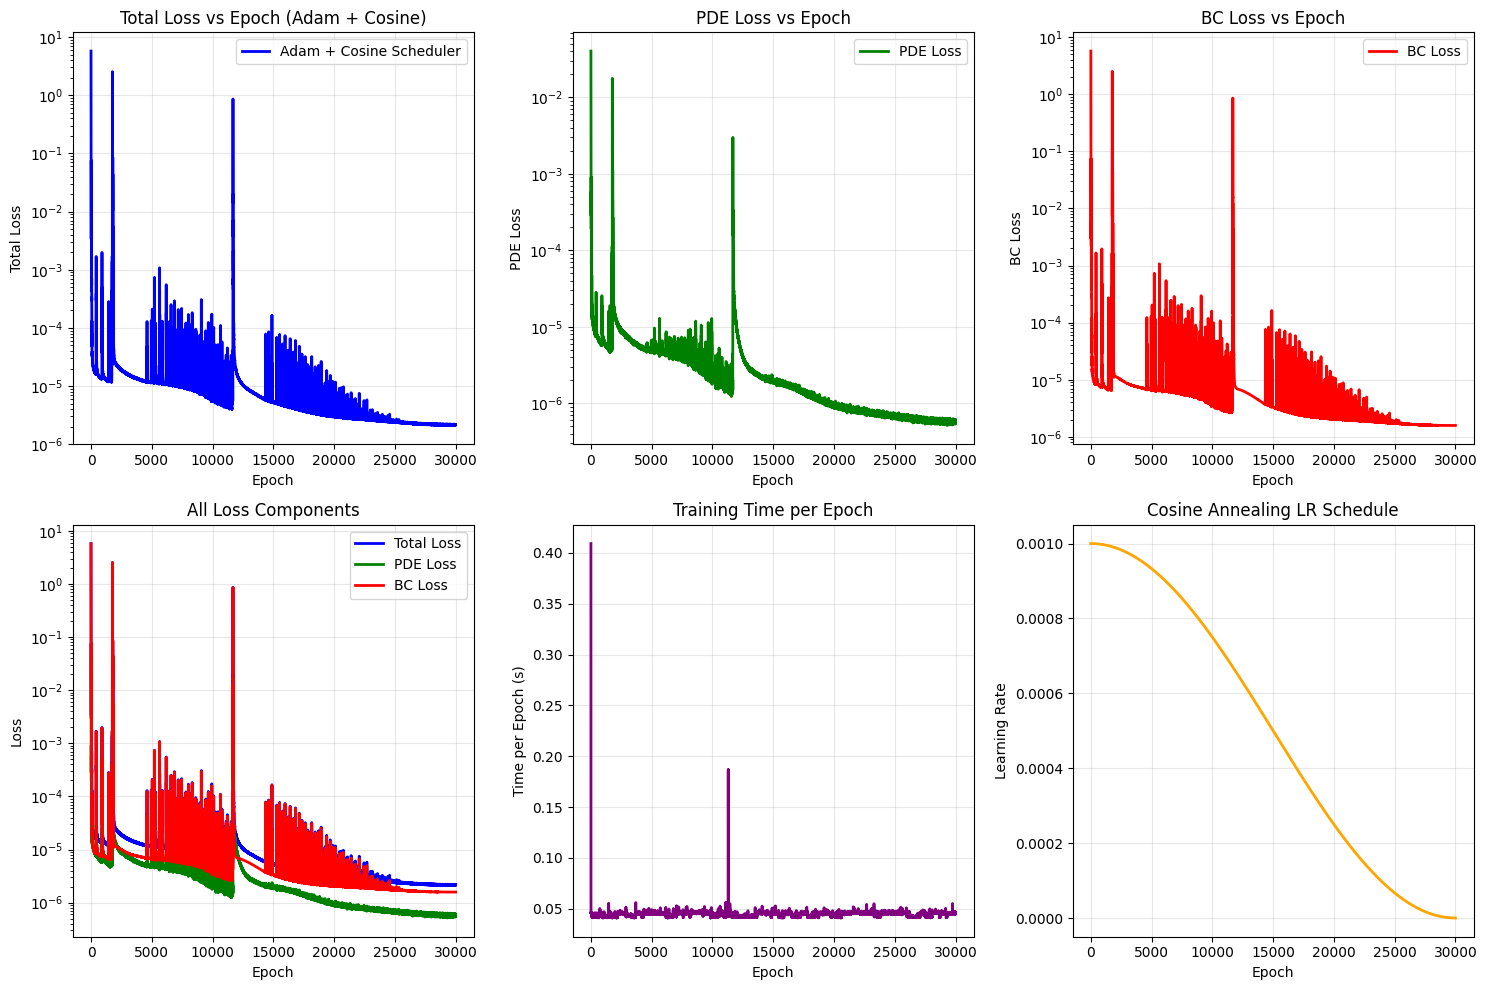


TRAINING SUMMARY (ADAM + COSINE SCHEDULER)
Total epochs: 30000
Optimizer: Adam with Cosine Annealing LR Scheduler
Initial LR: 0.001
Final LR: 1.00e-08
Min LR: 1.00e-08
Best loss achieved: 0.0000020979
Final loss: 0.0000021888
Total training time: 1329.72 seconds
Average time per epoch: 0.044 seconds
Best model saved to: best_model.pth

Final Loss Breakdown:
PDE Loss X: 0.0000003871
PDE Loss Y: 0.0000002179
BC Loss: 0.0000015838
Total: 0.0000021888
Results saved to PiNN3_data.csv


In [12]:
# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize network and optimizer
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    # Train the network
    trained_net, metrics = train_pin(net=net, optimizer=optimizer, n_epochs=30000)
    # Plot results
    try:
        plot_results(trained_net)
    except Exception as e:
        print(f"Error in plot_results: {str(e)}")